In [1]:
import numpy as np
from collections import Counter
from qiskit import IBMQ,Aer,schedule, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import timeline_drawer
from qiskit.visualization.pulse_v2 import draw, IQXDebugging
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import QuantumError, ReadoutError

# Tomography functions
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography


import KSEM
from importlib import reload  
KSEM = reload(KSEM)
from KSEM import KSQS
from KSEM import EMLearn

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# plt.rcParams['text.usetex'] = True
fig_size = (8,6)
fig_dpi = 150
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub="ibm-q-pnnl", group="internal", project="default")
name = "ibm_hanoi"
backend = provider.get_backend(name)
backend_noise_model = NoiseModel.from_backend(backend)
den_simu = AerSimulator(method='density_matrix',noise_model=backend_noise_model)
backend =  AerSimulator.from_backend(backend)

n_qubits = 3
reps = 8
max_num_itrs = 10

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (338785.39973037876 > 2 * 162953.29014502844). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (338785.39973037876 > 2 * 162953.29014502844). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum valu

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (338785.39973037876 > 2 * 162953.29014502844). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (0.00033878539973037876 > 2 * 0.00016295329014502844). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"


In [4]:
# backend.properties().to_dict()

In [7]:
# from qiskit.visualization import plot_error_map, plot_gate_map
# %matplotlib inline

# plot_error_map(backend)

In [8]:
from qiskit import Aer
def single_iter(n_qubits=2):
    iterate = QuantumCircuit(n_qubits)
    iterate.ry(np.pi/2,0)
    iterate.ry(np.pi/2,1)
    iterate.cx(0,1)
    iterate.ry(np.pi/2,0)
    iterate.ry(np.pi/2,1)
    iterate.barrier()
    iterate.ry(np.pi/2,1)
    iterate.ry(np.pi/2,2)
    iterate.cx(1,2)
    iterate.ry(np.pi/2,1)
    iterate.ry(np.pi/2,2)
    iterate.barrier()
    return iterate

def iterative_circ(num_itrs, n_qubits=2, save_den = True):   
    total_circ = QuantumCircuit(n_qubits)
    for i in range(num_itrs):
        total_circ.compose(single_iter(n_qubits), inplace=True)
#     total_circ.measure_all()
    if save_den:
        total_circ.save_density_matrix(pershot=False)
    return total_circ

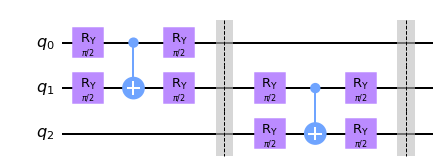

In [9]:
single_iter(n_qubits).draw("mpl")

14


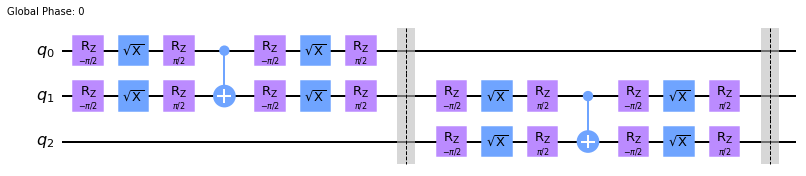

In [10]:
temp_circ = transpile(single_iter(n_qubits), backend=den_simu)
print(temp_circ.depth())
temp_circ.draw("mpl")

In [11]:
temp_circ2 = iterative_circ(max_num_itrs, n_qubits, save_den = False)
temp_circ3 = transpile(temp_circ2, backend=backend)
print("Depth:", temp_circ3.depth())
print("T1:", backend.properties().qubit_property(0)['T1'][0], "sec")
print("T2:", backend.properties().qubit_property(0)['T2'][0], "sec")
dt = backend.configuration().dt # sec
temp_sch = schedule(temp_circ3, backend)
print("Circuit Operation Time:",(temp_sch.stop_time - temp_sch.start_time)*dt, "sec")

Depth: 140
T1: 0.00015120846427874816 sec
T2: 0.00022384673752709456 sec


QiskitError: 'The backend defaults are unavailable. The backend may not support pulse.'

## Qiskit Backend-noise Simulation

Obtain measurement data and actual quantum states (from a backend-noise simulator)

Note that the outputs does not have measurement noise because the probabilities are obtained from density matrix object, instead of measurement operator API.

In [12]:
unitary_simulator = Aer.get_backend('aer_simulator')
unitary_circ = transpile(single_iter(n_qubits), backend=den_simu)
unitary_circ.save_unitary()
unitary_result = unitary_simulator.run(unitary_circ).result()
unitary = unitary_result.get_unitary(unitary_circ)

unitaries = []
for i in range(1, max_num_itrs+1):
    gate = unitary.data
    F = np.kron(gate.conjugate(), gate)
    unitaries.append(F)

In [13]:
np.random.seed(7)


total_simu_dens = [] # quantum state in density-matrix form
total_simu_probs = [] # measurement result
total_simu_purs = [] # purity
for i in range(1, max_num_itrs+1):
    trans_circ = transpile(iterative_circ(i, n_qubits), backend=den_simu)
    iter_res = den_simu.run(trans_circ,shots=8192*reps,seed_simulator=np.random.randint(10**8)).result()
    iter_den = iter_res.data()['density_matrix']
    total_simu_dens.append(iter_den)
    total_simu_probs.append(iter_den.probabilities())
    total_simu_purs.append(np.real(iter_den.purity()))
    
print("Purity")
for pu in total_simu_purs:
    print(pu)
    
print("\nProb Vec")
for p in total_simu_probs:
    print(p)

Purity
0.9407169700848794
0.8859185964925969
0.8355343306241143
0.7893070695273969
0.7460136856193604
0.7059686803653827
0.6691204177310593
0.6353077080135849
0.6035684630360233
0.5741917646998106

Prob Vec
[1.85829386e-05 1.85148727e-03 1.84652272e-05 1.22222895e-03
 6.02147869e-03 9.69744841e-01 5.85113942e-03 1.52717769e-02]
[2.08016416e-02 2.06175701e-02 9.40694397e-01 1.18103102e-02
 2.99769960e-03 9.85679517e-05 1.73717152e-03 1.24264246e-03]
[0.00290106 0.00133311 0.00191444 0.0030012  0.0345652  0.02598118
 0.91287101 0.01743279]
[0.88637079 0.02298    0.03929125 0.03927965 0.00296818 0.002967
 0.00307192 0.00307123]
[0.00316989 0.00475084 0.00307759 0.00411715 0.02846428 0.86052749
 0.0438906  0.05200216]
[0.05638025 0.05618921 0.83570665 0.03371628 0.00582586 0.00332334
 0.00464302 0.00421539]
[0.00574316 0.00438792 0.00497035 0.0059072  0.06781309 0.06042195
 0.81193812 0.03881821]
[0.78931237 0.04385519 0.07150388 0.0714637  0.00588029 0.00587973
 0.0060539  0.00605093]
[0.

## State Tomography

In [14]:
backend_noise_model_for_tomo = NoiseModel.from_backend(backend)
# Remove readout errros
p0given1 = 0
p1given0 = 0
rde = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
for i in range(backend.configuration().num_qubits):
    backend_noise_model_for_tomo._local_readout_errors[(i,)] = rde
den_simu_for_tomo = AerSimulator(method='density_matrix',noise_model=backend_noise_model_for_tomo)

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (338785.39973037876 > 2 * 162953.29014502844). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum value 2 * T_1 (338785.39973037876 > 2 * 162953.29014502844). Truncating to maximum value.
  warn("Device model returned an invalid T_2 relaxation time greater than"
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/qiskit/providers/aer/noise/device/models.py:264: UserWarning: Device model returned an invalid T_2 relaxation time greater than the theoretical maximum valu

In [15]:
np.random.seed(7)

tomo_dens = [] # quantum state in density-matrix form
tomo_probs = [] # measurement result
tomo_purs = [] # purity
for i in range(1, max_num_itrs+1):
    tomo_target_circ = transpile(iterative_circ(i, n_qubits, save_den = False), backend=den_simu_for_tomo)
    qstexp = StateTomography(tomo_target_circ)
    qstdata = qstexp.run(den_simu, seed_simulation=np.random.randint(10**8)).block_for_results()
    tomo_state =  qstdata.analysis_results("state")
    
    tomo_dens.append(tomo_state.value.data)
    tomo_probs.append(tomo_state.value.probabilities())
    tomo_purs.append(np.real(tomo_state.value.purity()))
    
print("Tomography Purity")
for pu in tomo_purs:
    print(pu)
    
print("\nTomography Prob Vec")
for p in tomo_probs:
    print(p)

Tomography Purity
0.8779488232036599
0.8267629955788729
0.7657064354112525
0.7549645699186487
0.7049878113250602
0.6560396102388628
0.6120622840037696
0.6115527782536764
0.5601037032516324
0.5348282700839062

Tomography Prob Vec
[0.00505724 0.01314011 0.00295188 0.0050904  0.01544785 0.93504209
 0.00613623 0.01713418]
[0.03523968 0.015413   0.90582908 0.01585923 0.00339683 0.00362474
 0.01482162 0.00581582]
[0.00964902 0.00289617 0.0142248  0.00544691 0.0488626  0.02010371
 0.87132165 0.02749514]
[0.86454935 0.0201914  0.04239858 0.04202631 0.01017728 0.00944684
 0.00915584 0.00205441]
[0.00885033 0.01390111 0.00707387 0.01031829 0.03561122 0.83385561
 0.03704383 0.05334574]
[0.07135658 0.05597535 0.80233422 0.0362976  0.00733914 0.00574579
 0.01542642 0.00552489]
[0.00616346 0.00597626 0.02013109 0.00884312 0.08504781 0.05799544
 0.77250727 0.04333554]
[0.77234746 0.04894948 0.06928622 0.06866685 0.00987094 0.00876494
 0.01772737 0.00438674]
[0.00811682 0.01767336 0.00582613 0.0107225

## Kalman Smoother

In [16]:
def vecden_meas(state):# H, measurement matrix for vectorized density matrix
    num_qubits = int(np.log2(np.sqrt(state.shape[0])))
    nrows = 2**num_qubits
    ncols = nrows**2
    mat = np.zeros((nrows, ncols), dtype=np.float64)
    for k in range(nrows):
        mat[k, nrows*k+k] = 1.0 # take out the diagonal terms in vectorized density matrix
    return np.real(mat.dot(state))

### Initialize

In [17]:
initial_state = np.array([0]*(total_simu_probs[0].size**2), dtype=complex)
initial_state[0] = 1

# initial state
num_dim = initial_state.size
x =initial_state
x[0]-= 0.01/num_dim
nrows = int(x.size-1)
for k in range(1,nrows+1):
    x[k] += 1/(num_dim*nrows)

In [18]:
# Other variance parameters
num_dim_state = initial_state.size
num_dim_obs = total_simu_probs[0].size

M = np.identity(num_dim_state, dtype=complex)* 0.02 * (1) # a guess for covariance matrix, E[(x0-xhat0^+)(x0-xhat0^+)^T]
Q = np.identity(num_dim_state, dtype=complex)* 0.2 * (1) # state covariance
R = np.identity(num_dim_obs, dtype=complex)* 0.1 * (1) # meas covariance
P = np.identity(num_dim_state, dtype=complex)* 0.05 * (1)# 

In [19]:
x.size,num_dim_state,num_dim_obs, unitaries[0].size

(64, 64, 8, 4096)

### EM and Smoother - Total

Use longest iterations

In [20]:
total_smoother_dens = []
total_smoother_purs = []

observs = total_simu_probs
learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented

# Slice from argumented system
realX0 = estX0.toarray()[:num_dim_state]
realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
x_seq, M_seq, M_prio_seq = smoother.smooth() 



# x_est_norms = []
# for j in range(max_num_itrs):
#     x_est = np.array(x_seq[j+1][:num_dim_state].todense()).flatten()
#     diag_sum = np.sum(vecden_meas(x_est))

#     #normalize along the diagonal
#     x_est_norm = x_est+0
#     nrows = int(np.sqrt(x_est.size))
#     for k in range(nrows):
#         x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
#     x_est_norms.append(x_est_norm)
#     final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)
#     total_smoother_dens.append(final_den)
#     total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))
for j in range(max_num_itrs):
    x_est = np.matrix(x_seq[j+1][:num_dim_state].todense()).flatten().reshape((num_dim_obs, num_dim_obs), order='F')
#     x_est = (x_est+x_est.H)/2
    final_den = KSEM.closed_den_mat(x_est)
    total_smoother_dens.append(final_den)
    total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Iteration statrts New ll -10770.17, Last ll -10780.17


Only use the estimation in the final iteration as the valid output

In [32]:
total_smoother_dens = []
total_smoother_purs = []
for i in range(1,max_num_itrs+1):
    observs = total_simu_probs[0:i]
    learn_obj = EMLearn(observs, unitaries[0], x, M, Q, R, P)
    estX0, estM0, estQ, estR, estF = learn_obj.learn() # they are all arguemented
    
    # Slice from argumented system
    realX0 = estX0.toarray()[:num_dim_state]
    realX0norm = np.sqrt(np.sum(np.abs(realX0)**2))
    realM0 = estM0.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
    realF = estF.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
    realQ = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state)]
    realR = estR.toarray()[range(num_dim_obs),:][:,range(num_dim_obs)]
    realP = estQ.toarray()[range(num_dim_state),:][:,range(num_dim_state, 2*num_dim_state)]

    smoother = KSQS(observs, realF, realX0, realM0, realQ, realR, realP)
    x_seq, M_seq, M_prio_seq = smoother.smooth() 
    
    # Normalization
    x_est = np.array(x_seq[-1][:num_dim_state].todense()).flatten()
    diag_sum = np.sum(vecden_meas(x_est))

    #normalize along the diagonal
    x_est_norm = x_est+0
    nrows = int(np.sqrt(x_est.size))
    for k in range(nrows):
        x_est_norm[k*nrows+k] = x_est_norm[k*nrows+k]/diag_sum
    final_den = x_est_norm.reshape(num_dim_obs, num_dim_obs)

#     x_est = np.matrix(x_seq[-1][:num_dim_state].todense()).flatten().reshape((num_dim_obs, num_dim_obs), order='F')
# #     x_est = (x_est+x_est.H)/2
#     final_den = KSEM.closed_den_mat(x_est)
    total_smoother_dens.append(final_den)
    total_smoother_purs.append(np.real(qi.DensityMatrix(final_den).purity()))

/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/firepanda415/anaconda3/envs/quantum/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


Iteration statrts New ll 236.65, Last ll 226.65
Iteration     1, New log-likelihood 2.42068e+02, Last log-likelihood 2.36647e+02, Change 5.42102e+00
Iteration     2, New log-likelihood 2.47333e+02, Last log-likelihood 2.42068e+02, Change 5.26527e+00
Iteration     3, New log-likelihood 2.52461e+02, Last log-likelihood 2.47333e+02, Change 5.12775e+00
Iteration     4, New log-likelihood 2.57462e+02, Last log-likelihood 2.52461e+02, Change 5.00193e+00
Iteration     5, New log-likelihood 2.62382e+02, Last log-likelihood 2.57462e+02, Change 4.91987e+00
Iteration     6, New log-likelihood 2.67265e+02, Last log-likelihood 2.62382e+02, Change 4.88311e+00
Iteration     7, New log-likelihood 2.72143e+02, Last log-likelihood 2.67265e+02, Change 4.87760e+00
Iteration     8, New log-likelihood 2.77051e+02, Last log-likelihood 2.72143e+02, Change 4.90838e+00
Iteration     9, New log-likelihood 2.82118e+02, Last log-likelihood 2.77051e+02, Change 5.06663e+00
Iteration    10, New log-likelihood 2.88101

In [33]:
for den in total_smoother_dens:
    print("Is state a valid density matrix:", qi.DensityMatrix(den).is_valid())

Is state a valid density matrix: False
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True
Is state a valid density matrix: True


In [34]:
with np.printoptions(precision=3, suppress=True):
#     for den in total_smoother_dens:
#         print(den)
    print(total_smoother_dens[8])

[[ 0.006-0.j -0.   +0.j -0.   +0.j  0.   -0.j  0.   +0.j -0.   +0.j
  -0.   +0.j  0.   +0.j]
 [-0.   -0.j  0.007-0.j  0.   +0.j -0.   +0.j -0.   +0.j  0.   +0.j
   0.   -0.j -0.   +0.j]
 [-0.   -0.j  0.   -0.j  0.006-0.j -0.   -0.j -0.   +0.j  0.   +0.j
   0.   -0.j -0.   -0.j]
 [ 0.   +0.j -0.   -0.j -0.   +0.j  0.006-0.j  0.   +0.j -0.   -0.j
  -0.   -0.j  0.   -0.j]
 [ 0.   -0.j -0.   -0.j -0.   -0.j  0.   -0.j  0.046+0.j -0.   +0.j
  -0.   -0.j  0.   +0.j]
 [-0.   -0.j  0.   -0.j  0.   -0.j -0.   +0.j -0.   -0.j  0.775+0.j
   0.   -0.j -0.   +0.j]
 [-0.   -0.j  0.   +0.j  0.   +0.j -0.   +0.j -0.   +0.j  0.   +0.j
   0.076-0.j -0.   +0.j]
 [ 0.   -0.j -0.   -0.j -0.   +0.j  0.   +0.j  0.   -0.j -0.   -0.j
  -0.   -0.j  0.078+0.j]]


In [35]:
print("Estimated Purity (Total)")
for pu in total_smoother_purs:
    print(pu)

Estimated Purity (Total)
0.9408325396950223
0.9008679557137389
0.8583186799622841
0.8083351641078907
0.7632736258769861
0.7210506176313586
0.6831538570967155
0.6476402444271333
0.6153268387546342
0.5846428954208189


## Check the fidelity between estimated state and the real state in the simulator

In [36]:
from scipy.linalg import sqrtm
def state_fid(m1,m2):
    sqm1 = sqrtm(m1)
    temp = sqm1.dot(m2).dot(sqm1)
    temp2 = sqrtm(temp)
    return np.real(np.trace(temp2))**2

In [37]:
# Compare fidelity, use Qiskit API (when every state from KS is a valid density matrix)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    qis_den_tomo = qi.DensityMatrix(tomo_dens[i])
    qis_den_all = qi.DensityMatrix(total_smoother_dens[i])
    fed_difference_tomo =  qi.state_fidelity(total_simu_dens[i], qis_den_tomo)
    fed_difference_all =  qi.state_fidelity(total_simu_dens[i], qis_den_all)
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed_qis.svg")
plt.show()

QiskitError: 'Input quantum state is not a valid'

Iteration 1 KS Fid: 0.9999467909582025 Tomo Fid: 0.9715783308010802
Iteration 2 KS Fid: 0.9993804477477485 Tomo Fid: 0.9680581114693433
Iteration 3 KS Fid: 0.9991766308537027 Tomo Fid: 0.9642714196822462
Iteration 4 KS Fid: 0.9995432111665034 Tomo Fid: 0.9667867366326849
Iteration 5 KS Fid: 0.9995817819900399 Tomo Fid: 0.9700484833407192
Iteration 6 KS Fid: 0.9997429784012605 Tomo Fid: 0.9783108613611537
Iteration 7 KS Fid: 0.9997202828959267 Tomo Fid: 0.9773880325398208
Iteration 8 KS Fid: 0.9998203808986291 Tomo Fid: 0.970462763551352
Iteration 9 KS Fid: 0.9997978166998472 Tomo Fid: 0.9701126699166138
Iteration 10 KS Fid: 0.9998657223789097 Tomo Fid: 0.9702914783838934


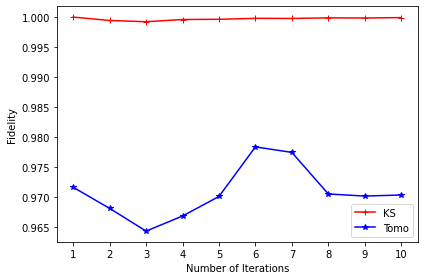

In [38]:
# Compare fidelity, use my own function (when some states from KS are not valid density matrices)
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    fed_difference_tomo =  state_fid(total_simu_dens[i].data, tomo_dens[i])
    fed_difference_all =  state_fid(total_simu_dens[i].data, total_smoother_dens[i])
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed.svg")
plt.show()

Iteration 1 KS Fid: 0.9999467909582025 Tomo Fid: 0.9715783308010802
Iteration 2 KS Fid: 0.9993804477477485 Tomo Fid: 0.9680581114693433
Iteration 3 KS Fid: 0.9991766308537027 Tomo Fid: 0.9642714196822462
Iteration 4 KS Fid: 0.9995432111665034 Tomo Fid: 0.9667867366326849
Iteration 5 KS Fid: 0.9995817819900399 Tomo Fid: 0.9700484833407192
Iteration 6 KS Fid: 0.9997429784012605 Tomo Fid: 0.9783108613611537
Iteration 7 KS Fid: 0.9997202828959267 Tomo Fid: 0.9773880325398208
Iteration 8 KS Fid: 0.9998203808986291 Tomo Fid: 0.970462763551352
Iteration 9 KS Fid: 0.9997978166998472 Tomo Fid: 0.9701126699166138
Iteration 10 KS Fid: 0.9998657223789097 Tomo Fid: 0.9702914783838934


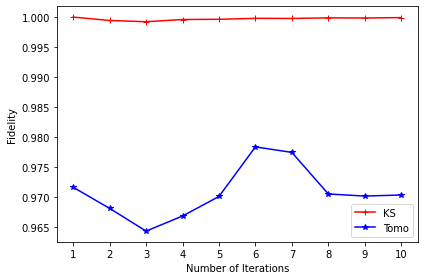

In [39]:
diff_fed_all= []
diff_fed_tomo= []
for i in range(max_num_itrs):
    fed_difference_tomo =  state_fid(total_simu_dens[i].data, tomo_dens[i])
    fed_difference_all =  state_fid(total_simu_dens[i].data, total_smoother_dens[i])
    diff_fed_all.append(fed_difference_all)
    diff_fed_tomo.append(fed_difference_tomo)
    print("Iteration",i+1, "KS Fid:", fed_difference_all, "Tomo Fid:", fed_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_fed_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_fed_tomo)[iter_range], '*-', color='blue', label='Tomo')
# plt.plot(np.array(iter_range)+1, np.array([0.9]*max_num_itrs)[iter_range], '--', color='lightgray')
plt.xlabel("Number of Iterations")
plt.ylabel("Fidelity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_fed.svg")
plt.show()

Iteration 1 KS Norm: 0.002657343013593752 Tomo Norm: 0.06524397420296216
Iteration 2 KS Norm: 0.00923547596716423 Tomo Norm: 0.07665463097559962
Iteration 3 KS Norm: 0.014926818794242732 Tomo Norm: 0.06981776329226808
Iteration 4 KS Norm: 0.012536931711976295 Tomo Norm: 0.06207428667483357
Iteration 5 KS Norm: 0.012567141464033996 Tomo Norm: 0.06838210808847767
Iteration 6 KS Norm: 0.010872471718919233 Tomo Norm: 0.061902138105186785
Iteration 7 KS Norm: 0.011316740876299107 Tomo Norm: 0.06587821481698064
Iteration 8 KS Norm: 0.00979631866160318 Tomo Norm: 0.0554187397484621
Iteration 9 KS Norm: 0.010440984930913385 Tomo Norm: 0.07720822472394485
Iteration 10 KS Norm: 0.009136853257531174 Tomo Norm: 0.07404820180909129


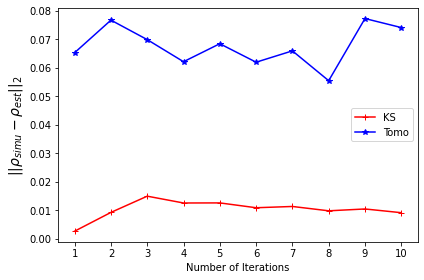

In [40]:
diff_norm_all= []
diff_norm_tomo= []
for i in range(max_num_itrs):
    norm_difference_tomo =  np.linalg.norm(total_simu_dens[i].data-tomo_dens[i])
    norm_difference_all =  np.linalg.norm(total_simu_dens[i].data-total_smoother_dens[i])
    diff_norm_all.append(norm_difference_all)
    diff_norm_tomo.append(norm_difference_tomo)
    print("Iteration",i+1, "KS Norm:", norm_difference_all, "Tomo Norm:", norm_difference_tomo)
    
iter_range = range(max_num_itrs)
plt.plot(np.array(iter_range)+1, np.array(diff_norm_all)[iter_range], '+-', color='red', label='KS')
plt.plot(np.array(iter_range)+1, np.array(diff_norm_tomo)[iter_range], '*-', color='blue', label='Tomo')
plt.xlabel("Number of Iterations")
plt.ylabel(r'$||\rho_{simu} - \rho_{est}||_2$', fontsize=14)
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_norm.svg")
plt.show()

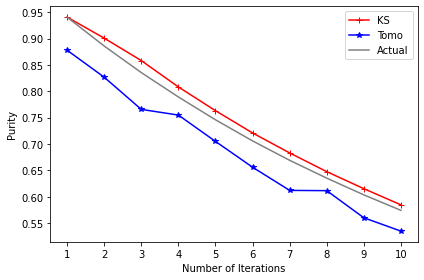

In [41]:
plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.array(tomo_purs)[iter_range], '*-', label="Tomo",color='blue')
# plt.plot(np.array(iter_range)+1, np.array(total_smoother_purs)[iter_range]-0.25, '+-', label="Estimated-0.25",color='skyblue')
plt.plot(np.array(iter_range)+1, np.array(total_simu_purs)[iter_range], label="Actual", color='gray')
plt.xlabel("Number of Iterations")
plt.ylabel("Purity")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_pur.svg")
plt.show()

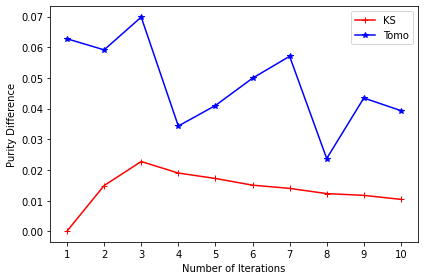

In [42]:
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(total_smoother_purs))[iter_range], '+-', label="KS",color='red')
plt.plot(np.array(iter_range)+1, np.abs(np.array(total_simu_purs)-np.array(tomo_purs))[iter_range], '*-', label="Tomo",color='blue')

plt.xlabel("Number of Iterations")
plt.ylabel("Purity Difference")
plt.xticks((np.array(iter_range)+1))
plt.legend()
plt.tight_layout()
# plt.savefig("diff_pur_diff.svg")
plt.show()